Import Libraries

In [ ]:
# code here
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch.nn as nn

from tqdm import tqdm
import time
import math

from tabulate import tabulate

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
print(device)

cuda


Using a PyTorch Dataset CIFAR-10

In [ ]:
from torch.utils.data import dataloader
# code here
transform = transforms.Compose([transforms.ToTensor(), ])

train_dataset = datasets.CIFAR10("root", train = True, transform=transform, download = True)
test_dataset = datasets.CIFAR10("root", train = False, transform=transform, download = True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 16, shuffle = True, num_workers = 2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 16, shuffle = True, num_workers = 2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting root/cifar-10-python.tar.gz to root
Files already downloaded and verified


torch.Size([16, 3, 32, 32])
torch.Size([16])
tensor([[[0.4392, 0.4314, 0.4588,  ..., 0.3725, 0.3686, 0.6392],
         [0.4471, 0.4784, 0.4941,  ..., 0.4000, 0.2431, 0.1725],
         [0.3608, 0.4039, 0.3804,  ..., 0.3765, 0.2863, 0.1490],
         ...,
         [0.7725, 0.7059, 0.6745,  ..., 0.6588, 0.6039, 0.2235],
         [0.4824, 0.1294, 0.1608,  ..., 0.1451, 0.1333, 0.1059],
         [0.6706, 0.4118, 0.4392,  ..., 0.4431, 0.4353, 0.4902]],

        [[0.5176, 0.5020, 0.5176,  ..., 0.4471, 0.4275, 0.6667],
         [0.5294, 0.5333, 0.5216,  ..., 0.4667, 0.2941, 0.1922],
         [0.4196, 0.4392, 0.3882,  ..., 0.4314, 0.3294, 0.1608],
         ...,
         [0.8000, 0.7333, 0.7020,  ..., 0.6980, 0.6314, 0.2235],
         [0.4941, 0.1412, 0.1725,  ..., 0.1529, 0.1333, 0.1020],
         [0.6745, 0.4157, 0.4431,  ..., 0.4353, 0.4275, 0.4863]],

        [[0.2627, 0.2549, 0.2706,  ..., 0.2471, 0.2784, 0.6471],
         [0.2980, 0.3020, 0.3020,  ..., 0.2980, 0.1647, 0.1765],
         [0.2

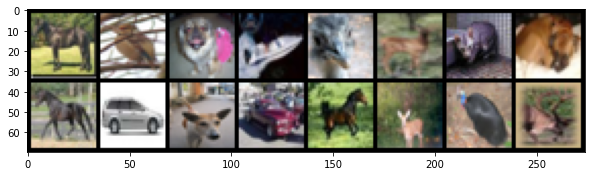

In [ ]:
# let's have a look at the dataset
def imshow(img):
    img = img #/ 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# show images
print(images[0])
imshow(torchvision.utils.make_grid(images))

In [ ]:
# TRAINING
def TrainModel(p_Model, p_Epochs, p_trainloader, p_criteria, p_optim, p_reshape = False):
    StartTime = time.time()

    Loss = []
    for epoch in range(p_Epochs):
        TotalLoss = 0
        for inputs, _ in tqdm(p_trainloader):
            if p_reshape == True:
                inputs = inputs.reshape(inputs.shape[0], -1)
            inputs = inputs.to(device)
            # input = input.view(-1, input.shape[0]*input.shape[1]*input.shape[2])

            encoded, decoded = p_Model(inputs)
            loss = p_criteria(decoded, inputs)

            p_optim.zero_grad()
            loss.backward()
            p_optim.step()

            TotalLoss += loss.item()

        Loss.append(TotalLoss/len(train_loader))
        print("EPOCH - ", epoch+1, " LOSS=", TotalLoss/len(train_loader))

    EndTime = time.time()

    return EndTime - StartTime, Loss


def PrintReconstructedImage(p_Model, p_testloader, p_reshape = False):
    print("Original Images")
    dataiter = iter(p_testloader)
    images, labels = next(dataiter)
    # for data in test_loader:
    #     images = data[0]
    #     break

    imshow(torchvision.utils.make_grid(images))
    if p_reshape == True:
        images = images.reshape(images.shape[0], -1)
    images = images.to(device)


    print("Reconstructed Images")
    decoded_images = p_Model(images)[1]
    if p_reshape == True:
        decoded_images = decoded_images.reshape(decoded_images.shape[0], 3, 32, 32)
    imshow(torchvision.utils.make_grid(decoded_images.cpu()))


def PlotLoss(X, Y, model):
    plt.figure()
    plt.title("Train loss for " + str(model))
    plt.plot(X, Y)

## Part 1: Auto-Encoder
3 Models for Auto-Encoder
1. MLP-only model
2. CNN-MLP combination model
3. CNN-only model

In [ ]:
class MLPAutoEncoder(nn.Module):
    # code
    def __init__(self):
        super(MLPAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(3072, 1700),
            nn.ReLU(),
            nn.Linear(1700, 600),
            nn.ReLU(),
            nn.Linear(600, 32),
            nn.ReLU(),
            nn.Flatten()
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 600),
            nn.Sigmoid(),
            nn.Linear(600, 1700),
            nn.Sigmoid(),
            nn.Linear(1700, 3072),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return encoded, decoded

In [ ]:
# class CNNAutoEncoder(nn.Module):
#     # code
#     def __init__(self, outSize):
#         super(CNNAutoEncoder, self).__init__()
#         self.sizes = [math.ceil((i+1)*outSize/3) for i in range(3)]
#         self.encoder = nn.Sequential(
#             nn.Conv2d(3, self.sizes[0], 5),
#             nn.ReLU(),
#             nn.Conv2d(self.sizes[0], self.sizes[1], 5),
#             nn.ReLU(),
#             nn.Conv2d(self.sizes[1], self.sizes[2], 5),
#             nn.ReLU()
#         )
#         self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(self.sizes[2], self.sizes[1], 5),
#             nn.ReLU(),
#             nn.ConvTranspose2d(self.sizes[1], self.sizes[0], 5),
#             nn.ReLU(),
#             nn.ConvTranspose2d(self.sizes[0], 3, 5),
#             nn.ReLU()
#         )

#     def forward(self, x):
#         encoded = self.encoder(x)
#         decoded = self.decoder(encoded)

#         return encoded, decoded

In [ ]:
class CNNAutoEncoder_32(nn.Module):
    # code
    def __init__(self):
        super(CNNAutoEncoder_32, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 4, kernel_size=4, stride=2), # 4*15*15
            nn.ReLU(),
            nn.Conv2d(4, 6, kernel_size=3, stride=2),# 6*7*7
            nn.ReLU(),
            nn.Conv2d(6, 8, kernel_size=4 ),# 8*4*4
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 6, kernel_size=4),
            nn.ReLU(),
            nn.ConvTranspose2d(6, 4, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(4, 3, kernel_size=4, stride=2),
            nn.ReLU()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return encoded, decoded

In [ ]:
class ComboAutoEncoder(nn.Module):
    # code GUDDA MUSUKONI KURCHO
    def __init__(self):
        super(ComboAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 9, 5),
            nn.ReLU(),
            nn.Conv2d(9, 18, 5),
            nn.ReLU(),

            nn.Flatten(),
            nn.Linear(18*24*24, 32),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 18*24*24),
            nn.ReLU(),
            nn.Unflatten(1, (18, 24, 24)),

            nn.ConvTranspose2d(18, 9, 5),
            nn.ReLU(),
            nn.ConvTranspose2d(9, 3, 5),
            nn.ReLU()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return encoded, decoded

In [ ]:
# # sample code for a autoencoder:
# class Autoencoder(nn.Module):
#     def __init__(self):
#         super(Autoencoder, self).__init__()
#         # Input size: [batch, 3, 32, 32]
#         # Output size: [batch, 3, 32, 32]
#         # Representation size: 3072
#         # Number of Layers for encoder: 1
#         # Number of Layers for decoder: 1
#         self.encoder = nn.Sequential(
#             nn.Conv2d(3, 12, 4, stride=2, padding=1), # 3x32x32 -> 12x16x16
#             nn.ReLU(),
#             nn.Flatten(), # 12x16x16 -> 3072
#         )
#         self.decoder = nn.Sequential(
#             nn.Unflatten(1, (12, 16, 16)), # 3072 -> 12x16x16
#             nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1), # 12x16x16 -> 3x32x32
#             nn.Sigmoid(),
#         )
#     def forward(self, x):
#         encoded = self.encoder(x)
#         decoded = self.decoder(encoded)
#         return encoded, decoded


### Step two: Using MSELoss to train all the models and analyse results

In [ ]:
# # code here
# criteria = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(),weight_decay=1e-5, lr=1e-3)

EPOCHS = 5
EpochList = [i+1 for i in range(EPOCHS)]

--------------MLP--------------


100%|██████████| 3125/3125 [00:32<00:00, 95.93it/s] 


EPOCH -  1  LOSS= 0.03940545794248581


100%|██████████| 3125/3125 [00:34<00:00, 90.82it/s] 


EPOCH -  2  LOSS= 0.03817022875726223


100%|██████████| 3125/3125 [00:33<00:00, 93.94it/s]


EPOCH -  3  LOSS= 0.038119300869107246


100%|██████████| 3125/3125 [00:34<00:00, 90.52it/s] 


EPOCH -  4  LOSS= 0.03809850386679173


100%|██████████| 3125/3125 [00:32<00:00, 95.21it/s] 

EPOCH -  5  LOSS= 0.03807139841973781
Original Images


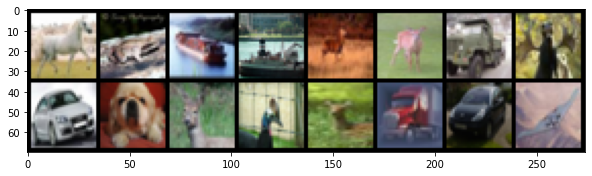

Reconstructed Images


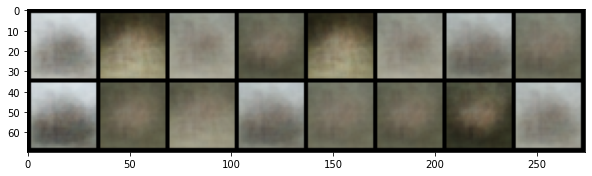

In [ ]:
#--------------MLP--------------#
modelMLP = MLPAutoEncoder().to(device)
# print(modelMLP.encoder)
# print(modelMLP.decoder)

criteria = nn.MSELoss()
optimizer = torch.optim.Adam(modelMLP.parameters(), lr=1e-3, weight_decay=1e-5)

print("--------------MLP--------------")
timeTakenMLP, lossListMLP = TrainModel(modelMLP, EPOCHS, train_loader, criteria, optimizer, p_reshape = True)

PrintReconstructedImage(modelMLP, test_loader, p_reshape = True)

--------------COMBO--------------


100%|██████████| 3125/3125 [00:24<00:00, 125.15it/s]


EPOCH -  1  LOSS= 0.024381579057574272


100%|██████████| 3125/3125 [00:25<00:00, 124.30it/s]


EPOCH -  2  LOSS= 0.01811096718877554


100%|██████████| 3125/3125 [00:24<00:00, 126.21it/s]


EPOCH -  3  LOSS= 0.017503533186018466


100%|██████████| 3125/3125 [00:31<00:00, 98.32it/s]


EPOCH -  4  LOSS= 0.017407609844207764


100%|██████████| 3125/3125 [00:40<00:00, 77.27it/s]

EPOCH -  5  LOSS= 0.017343904567658903
Original Images


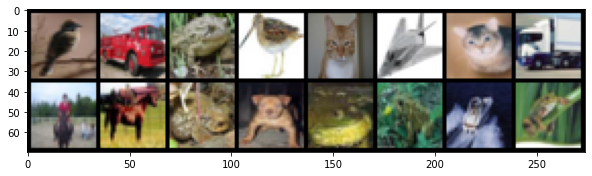

Reconstructed Images


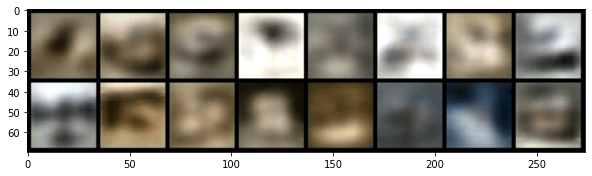

In [ ]:
#--------------Combo--------------#
modelCOMBO = ComboAutoEncoder().to(device)
# print(modelCOMBO.encoder)
# print(modelCOMBO.decoder)

criteria = nn.MSELoss()
optimizer = torch.optim.Adam(modelCOMBO.parameters(), lr=1e-3, weight_decay=1e-5)

print("--------------COMBO--------------")
timeTakenCOMBO, lossListCOMBO = TrainModel(modelCOMBO, EPOCHS, train_loader, criteria, optimizer, p_reshape = False)

PrintReconstructedImage(modelCOMBO, test_loader, p_reshape = False)

CNNAutoEncoder_32(
  (encoder): Sequential(
    (0): Conv2d(3, 4, kernel_size=(4, 4), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(4, 6, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(6, 8, kernel_size=(4, 4), stride=(1, 1))
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(8, 6, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(6, 4, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): ConvTranspose2d(4, 3, kernel_size=(4, 4), stride=(2, 2))
    (5): ReLU()
  )
)
--------------CNN--------------


100%|██████████| 3125/3125 [00:27<00:00, 113.87it/s]


EPOCH -  1  LOSS= 0.026622883262336253


100%|██████████| 3125/3125 [00:32<00:00, 95.70it/s] 


EPOCH -  2  LOSS= 0.015527385316193104


100%|██████████| 3125/3125 [00:32<00:00, 97.47it/s] 


EPOCH -  3  LOSS= 0.014568951223790646


100%|██████████| 3125/3125 [00:32<00:00, 97.53it/s]


EPOCH -  4  LOSS= 0.013627046334147453


100%|██████████| 3125/3125 [00:29<00:00, 105.06it/s]

EPOCH -  5  LOSS= 0.012323911917358637
Original Images


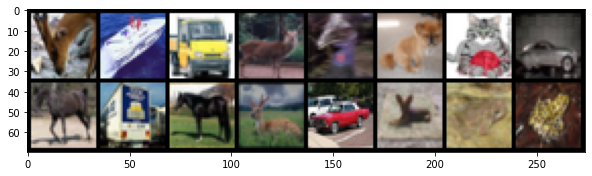

Reconstructed Images


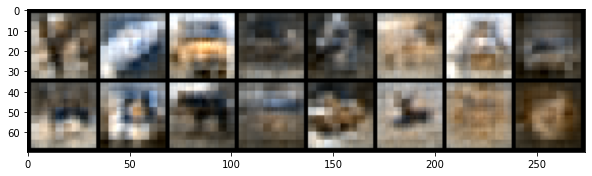

In [ ]:
#--------------CNN--------------#
modelCNN = CNNAutoEncoder_32().to(device)
print(modelCNN)
# print(modelCNN.encoder)
# print(modelCNN.decoder)

criteria = nn.MSELoss()
optimizer = torch.optim.Adam(modelCNN.parameters(), lr=1e-3, weight_decay=1e-5)

print("--------------CNN--------------")
timeTakenCNN, lossListCNN = TrainModel(modelCNN, EPOCHS, train_loader, criteria, optimizer, p_reshape = False)

PrintReconstructedImage(modelCNN, test_loader, p_reshape = False)

In [ ]:
# #--------------CNN--------------#
# dataiter = iter(train_loader)
# for data, target in dataiter

In [ ]:
# # Utilize the following code
# #--------------MLP--------------#
# dataiter = iter(testloader)
# images, labels = dataiter.next()
# print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(5)))
# imshow(torchvision.utils.make_grid(images))

# images = Variable(images)

# print("Reconstructed image")
# decoded_imgs = autoencoder(images)[1]
# imshow(torchvision.utils.make_grid(decoded_imgs.data))

# #--------------Combo--------------#
# dataiter = iter(testloader)
# images, labels = dataiter.next()
# print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(5)))
# imshow(torchvision.utils.make_grid(images))

# images = Variable(images)

# print("Reconstructed image")
# decoded_imgs = autoencoder(images)[1]
# imshow(torchvision.utils.make_grid(decoded_imgs.data))

# #--------------CNN--------------#
# dataiter = iter(testloader)
# images, labels = dataiter.next()
# print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(5)))
# imshow(torchvision.utils.make_grid(images))

# images = Variable(images)

# print("Reconstructed image")
# decoded_imgs = autoencoder(images)[1]
# imshow(torchvision.utils.make_grid(decoded_imgs.data))

--------------MLP--------------
MLPAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=3072, out_features=1700, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1700, out_features=600, bias=True)
    (3): ReLU()
    (4): Linear(in_features=600, out_features=32, bias=True)
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=600, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=600, out_features=1700, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=1700, out_features=3072, bias=True)
    (5): Sigmoid()
  )
)
Total Number of Model Parameters 12530904
Time taken to train MLP model for 1 EPOCH -  33.52713289260864

--------------COMBO--------------
ComboAutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(3, 9, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(9, 18, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-

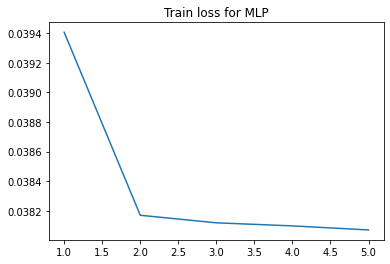

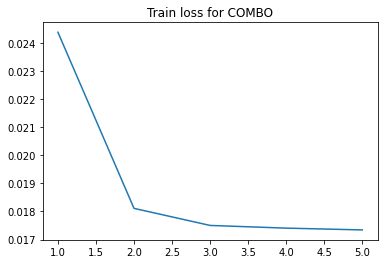

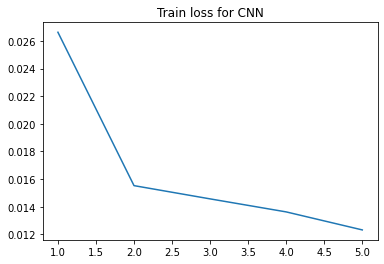

In [ ]:
# analysis, plots and tabulations here
print("--------------MLP--------------")
print(modelMLP)
modelMLP_total_params = sum(p.numel() for p in modelMLP.parameters())
print("Total Number of Model Parameters", modelMLP_total_params)
print("Time taken to train MLP model for 1 EPOCH - ", timeTakenMLP/EPOCHS)
PlotLoss(EpochList, lossListMLP, "MLP")
print()

print("--------------COMBO--------------")
print(modelCOMBO)
modelCOMBO_total_params = sum(p.numel() for p in modelCOMBO.parameters())
print("Model Parameters", modelCOMBO_total_params)
print("Time taken to train COMBO model for 1 EPOCH - ", timeTakenCOMBO/EPOCHS)
PlotLoss(EpochList, lossListCOMBO, "COMBO")
print()

print("--------------CNN--------------")
print(modelCNN)
modelCNN_total_params = sum(p.numel() for p in modelCNN.parameters())
print("Model Parameters", modelCNN_total_params)
print("Time taken to train CNN model for 1 EPOCH - ", timeTakenCNN/EPOCHS)
PlotLoss(EpochList, lossListCNN, "CNN")
print()

print("Avg Epoch Loss")
LossTable = []
for i in range(EPOCHS):
    tmp = []
    tmp.append(i+1)
    tmp.append(lossListMLP[i])
    tmp.append(lossListCOMBO[i])
    tmp.append(lossListCNN[i])

    LossTable.append(tmp)

head = ["Epoch", "MLP", "COMBO", "CNN"]
print(tabulate(LossTable, headers=head, tablefmt="grid"))

### Step three: Models With Representation Sizes
1. 10
2. 32
3. 100
4. 1000

In [ ]:
class CNNAutoEncoder_10(nn.Module):
    # code
    def __init__(self):
        super(CNNAutoEncoder_10, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 5, kernel_size=4, stride=2), # 5*15*15
            nn.ReLU(),
            nn.Conv2d(5, 8, kernel_size=3, stride=2),# 8*7*7
            nn.ReLU(),
            nn.Conv2d(8, 10, kernel_size=7 ),# 10*1*1
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(10, 8, kernel_size=7),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 5, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(5, 3, kernel_size=4, stride=2),
            nn.ReLU()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return encoded, decoded


class CNNAutoEncoder_100(nn.Module):
    # code
    def __init__(self):
        super(CNNAutoEncoder_100, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3,9,4,stride=2,padding=1),#N,9,16,16
            nn.ReLU(),
            nn.Conv2d(9,18,4,stride=2,padding=1),#N,18,8,8
            nn.ReLU(),
            nn.Conv2d(18,25,4,stride=4), #N,25,2,2
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(25,18,4,stride=4),# 18,8,8
            nn.ReLU(),
            nn.ConvTranspose2d(18,9,4,stride=2,padding=1), #9,16,16
            nn.ReLU(),
            nn.ConvTranspose2d(9,3,4,stride=2,padding=1), # 3,32,32
            nn.ReLU()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return encoded, decoded

class CNNAutoEncoder_1000(nn.Module):
    # code
    def __init__(self):
        super(CNNAutoEncoder_1000, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3,90,4,stride=2,padding=1),#N,90,16,16
            nn.ReLU(),
            nn.Conv2d(90,180,4,stride=2,padding=1),#N,180,8,8
            nn.ReLU(),
            nn.Conv2d(180,250,4,stride=4), #N,250,2,2
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(250,180,4,stride=4),# 180,8,8
            nn.ReLU(),
            nn.ConvTranspose2d(180,90,4,stride=2,padding=1), #90,16,16
            nn.ReLU(),
            nn.ConvTranspose2d(90,3,4,stride=2,padding=1), # 3,32,32
            nn.ReLU(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return encoded, decoded

CNNAutoEncoder_10(
  (encoder): Sequential(
    (0): Conv2d(3, 5, kernel_size=(4, 4), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(5, 8, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(8, 10, kernel_size=(7, 7), stride=(1, 1))
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(10, 8, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(8, 5, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): ConvTranspose2d(5, 3, kernel_size=(4, 4), stride=(2, 2))
    (5): ReLU()
  )
)
--------------CNN Rep Size 10--------------


100%|██████████| 3125/3125 [00:31<00:00, 99.23it/s] 


EPOCH -  1  LOSS= 0.03190644263863564


100%|██████████| 3125/3125 [00:24<00:00, 127.17it/s]


EPOCH -  2  LOSS= 0.02642525664329529


100%|██████████| 3125/3125 [00:24<00:00, 127.01it/s]


EPOCH -  3  LOSS= 0.026246075233221054


100%|██████████| 3125/3125 [00:24<00:00, 127.57it/s]


EPOCH -  4  LOSS= 0.026167629302740098


100%|██████████| 3125/3125 [00:24<00:00, 127.19it/s]

EPOCH -  5  LOSS= 0.026116302856802942
Original Images


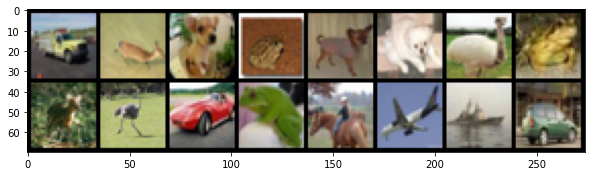

Reconstructed Images


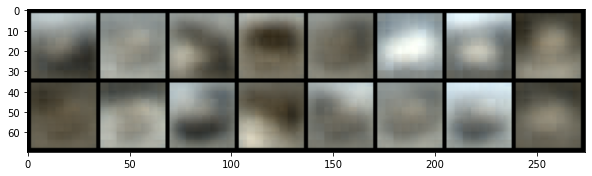

In [ ]:
#--------------CNN Rep Size 10--------------#
modelCNN_10 = CNNAutoEncoder_10().to(device)
print(modelCNN_10)
# print(modelCNN.encoder)
# print(modelCNN.decoder)

criteria = nn.MSELoss()
optimizer = torch.optim.Adam(modelCNN_10.parameters(), lr=1e-3, weight_decay=1e-5)

print("--------------CNN Rep Size 10--------------")
timeTakenCNN_10, lossListCNN_10 = TrainModel(modelCNN_10, EPOCHS, train_loader, criteria, optimizer, p_reshape = False)

PrintReconstructedImage(modelCNN_10, test_loader, p_reshape = False)

CNNAutoEncoder_32(
  (encoder): Sequential(
    (0): Conv2d(3, 4, kernel_size=(4, 4), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(4, 6, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(6, 8, kernel_size=(4, 4), stride=(1, 1))
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(8, 6, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(6, 4, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): ConvTranspose2d(4, 3, kernel_size=(4, 4), stride=(2, 2))
    (5): ReLU()
  )
)
--------------CNN Rep Size 32--------------


100%|██████████| 3125/3125 [00:24<00:00, 128.58it/s]


EPOCH -  1  LOSS= 0.025901425116956235


100%|██████████| 3125/3125 [00:26<00:00, 120.17it/s]


EPOCH -  2  LOSS= 0.01596167119383812


100%|██████████| 3125/3125 [00:32<00:00, 95.24it/s]


EPOCH -  3  LOSS= 0.015224230643212796


100%|██████████| 3125/3125 [00:25<00:00, 124.12it/s]


EPOCH -  4  LOSS= 0.01481197919100523


100%|██████████| 3125/3125 [00:24<00:00, 126.33it/s]

EPOCH -  5  LOSS= 0.014592043820619583
Original Images


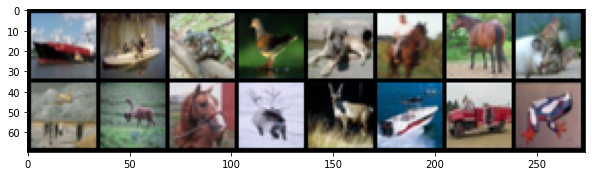

Reconstructed Images


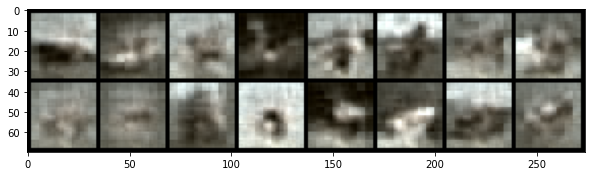

In [ ]:
#--------------CNN Rep Size 32--------------#
modelCNN_32 = CNNAutoEncoder_32().to(device)
print(modelCNN_32)
# print(modelCNN.encoder)
# print(modelCNN.decoder)

criteria = nn.MSELoss()
optimizer = torch.optim.Adam(modelCNN_32.parameters(), lr=1e-3, weight_decay=1e-5)

print("--------------CNN Rep Size 32--------------")
timeTakenCNN_32, lossListCNN_32 = TrainModel(modelCNN_32, EPOCHS, train_loader, criteria, optimizer, p_reshape = False)

PrintReconstructedImage(modelCNN_32, test_loader, p_reshape = False)

CNNAutoEncoder_100(
  (encoder): Sequential(
    (0): Conv2d(3, 9, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(9, 18, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(18, 25, kernel_size=(4, 4), stride=(4, 4))
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(25, 18, kernel_size=(4, 4), stride=(4, 4))
    (1): ReLU()
    (2): ConvTranspose2d(18, 9, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(9, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
  )
)
--------------CNN Rep Size 100--------------


100%|██████████| 3125/3125 [00:25<00:00, 121.05it/s]


EPOCH -  1  LOSS= 0.016022528022527696


100%|██████████| 3125/3125 [00:28<00:00, 110.08it/s]


EPOCH -  2  LOSS= 0.008445147295445203


100%|██████████| 3125/3125 [00:26<00:00, 119.88it/s]


EPOCH -  3  LOSS= 0.008105101823955775


100%|██████████| 3125/3125 [00:25<00:00, 123.65it/s]


EPOCH -  4  LOSS= 0.007994750970304013


100%|██████████| 3125/3125 [00:26<00:00, 119.98it/s]

EPOCH -  5  LOSS= 0.007949201477468014
Original Images


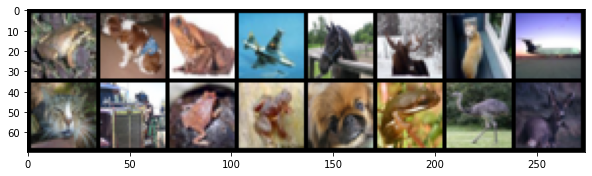

Reconstructed Images


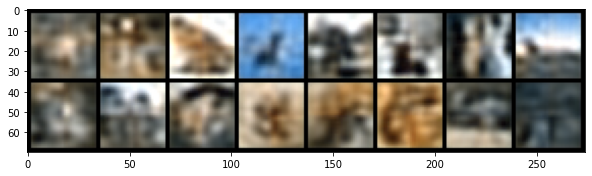

In [ ]:
#--------------CNN Rep Size 100--------------#
modelCNN_100 = CNNAutoEncoder_100().to(device)
print(modelCNN_100)
# print(modelCNN.encoder)
# print(modelCNN.decoder)

criteria = nn.MSELoss()
optimizer = torch.optim.Adam(modelCNN_100.parameters(), lr=1e-3, weight_decay=1e-5)

print("--------------CNN Rep Size 100--------------")
timeTakenCNN_100, lossListCNN_100 = TrainModel(modelCNN_100, EPOCHS, train_loader, criteria, optimizer, p_reshape = False)

PrintReconstructedImage(modelCNN_100, test_loader, p_reshape = False)

CNNAutoEncoder_1000(
  (encoder): Sequential(
    (0): Conv2d(3, 90, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(90, 180, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(180, 250, kernel_size=(4, 4), stride=(4, 4))
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(250, 180, kernel_size=(4, 4), stride=(4, 4))
    (1): ReLU()
    (2): ConvTranspose2d(180, 90, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(90, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
  )
)
--------------CNN Rep Size 1000--------------


100%|██████████| 3125/3125 [00:33<00:00, 94.23it/s] 


EPOCH -  1  LOSS= 0.00892174402087927


100%|██████████| 3125/3125 [00:25<00:00, 120.28it/s]


EPOCH -  2  LOSS= 0.0028018793122842906


100%|██████████| 3125/3125 [00:26<00:00, 119.04it/s]


EPOCH -  3  LOSS= 0.0020041299375519158


100%|██████████| 3125/3125 [00:26<00:00, 118.52it/s]


EPOCH -  4  LOSS= 0.0017294114226102828


100%|██████████| 3125/3125 [00:27<00:00, 115.66it/s]

EPOCH -  5  LOSS= 0.0015683954250253736
Original Images


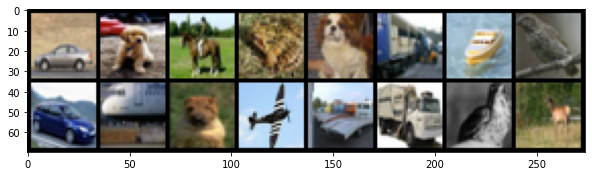

Reconstructed Images


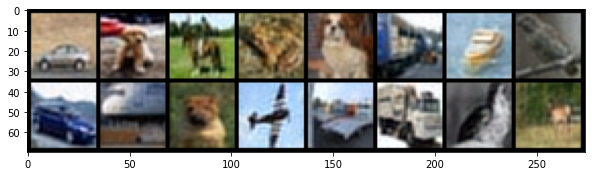

In [ ]:
#--------------CNN Rep Size 1000--------------#
modelCNN_1000 = CNNAutoEncoder_1000().to(device)
print(modelCNN_1000)
# print(modelCNN.encoder)
# print(modelCNN.decoder)

criteria = nn.MSELoss()
optimizer = torch.optim.Adam(modelCNN_1000.parameters(), lr=1e-3, weight_decay=1e-5)

print("--------------CNN Rep Size 1000--------------")
timeTakenCNN_1000, lossListCNN_1000 = TrainModel(modelCNN_1000, EPOCHS, train_loader, criteria, optimizer, p_reshape = False)

PrintReconstructedImage(modelCNN_1000, test_loader, p_reshape = False)

Increasing the representation size is increasing the complexity of the network. However I could observe that this is causing good effect of improving the image reconstruction quality. For my case (Num of Epochs=10), increasing representation size to 1000 is also having good results w.r.t Reconstrucition quality. However having trained for more number of EPOCHS could have led to model overfitting for high Representation sizes.

--------------CNN Rep Size 100--------------
CNNAutoEncoder_10(
  (encoder): Sequential(
    (0): Conv2d(3, 5, kernel_size=(4, 4), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(5, 8, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(8, 10, kernel_size=(7, 7), stride=(1, 1))
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(10, 8, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(8, 5, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): ConvTranspose2d(5, 3, kernel_size=(4, 4), stride=(2, 2))
    (5): ReLU()
  )
)
Total Number of Model Parameters 1967833
Time taken to train per Epoch -  25.95576958656311

--------------CNN Rep Size 32--------------
CNNAutoEncoder_32(
  (encoder): Sequential(
    (0): Conv2d(3, 4, kernel_size=(4, 4), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(4, 6, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(6, 8, kernel_size=(4, 4), stride=(1, 1))
    (5): ReLU()
  )
  (de

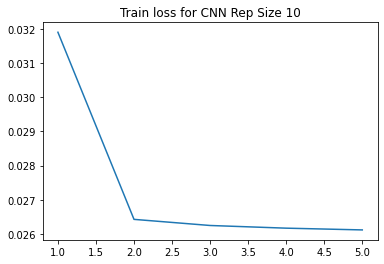

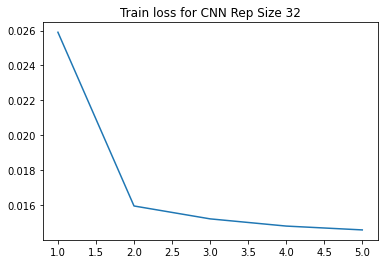

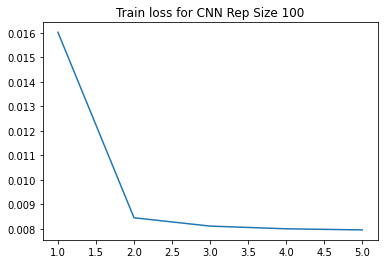

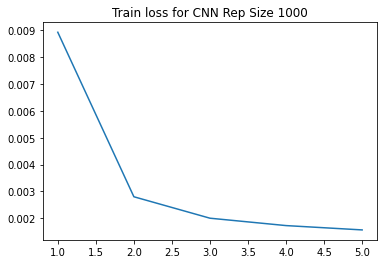

In [ ]:
# analysis, plots and tabulations here
print("--------------CNN Rep Size 100--------------")
print(modelCNN_10)
modelCNN_total_params = sum(p.numel() for p in modelCNN_1000.parameters())
print("Total Number of Model Parameters", modelCNN_total_params)
print("Time taken to train per Epoch - ", timeTakenCNN_10/EPOCHS)
PlotLoss(EpochList, lossListCNN_10, "CNN Rep Size 10")
print()

print("--------------CNN Rep Size 32--------------")
print(modelCNN_32)
modelCNN_total_params = sum(p.numel() for p in modelCNN_32.parameters())
print("Total Number of Model Parameters", modelCNN_total_params)
print("Time taken to train per Epoch - ", timeTakenCNN_32/EPOCHS)
PlotLoss(EpochList, lossListCNN_32, "CNN Rep Size 32")
print()

print("--------------CNN Rep Size 100--------------")
print(modelCNN_100)
modelCNN_total_params = sum(p.numel() for p in modelCNN_100.parameters())
print("Total Number of Model Parameters", modelCNN_total_params)
print("Time taken to train per Epoch - ", timeTakenCNN_100/EPOCHS)
PlotLoss(EpochList, lossListCNN_100, "CNN Rep Size 100")
print()

print("--------------CNN Rep Size 1000--------------")
print(modelCNN_1000)
modelCNN_total_params = sum(p.numel() for p in modelCNN_1000.parameters())
print("Total Number of Model Parameters", modelCNN_total_params)
print("Time taken to train per Epoch - ", timeTakenCNN_1000/EPOCHS)
PlotLoss(EpochList, lossListCNN_1000, "CNN Rep Size 1000")
print()
print("Avg Epoch Loss")
LossTable = []
for i in range(EPOCHS):
    tmp = []
    tmp.append(i+1)
    tmp.append(lossListCNN_10[i])
    tmp.append(lossListCNN_32[i])
    tmp.append(lossListCNN_100[i])
    tmp.append(lossListCNN_1000[i])

    LossTable.append(tmp)

head = ["EPOCH", "Size 10", "Size 32", "Size 100", "Size 1000"]
print(tabulate(LossTable, headers=head, tablefmt="grid"))

REPRESENTATION SIZE :  10
CNNAutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(3, 4, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(4, 7, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(7, 10, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(10, 7, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(7, 4, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(4, 3, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU()
  )
)


100%|██████████| 3125/3125 [00:25<00:00, 123.68it/s]


EPOCH -  1  LOSS= 0.01795195363074541


100%|██████████| 3125/3125 [00:25<00:00, 123.50it/s]


EPOCH -  2  LOSS= 0.01022964928150177


100%|██████████| 3125/3125 [00:25<00:00, 123.30it/s]


EPOCH -  3  LOSS= 0.009419512910842896


100%|██████████| 3125/3125 [00:25<00:00, 121.02it/s]


EPOCH -  4  LOSS= 0.009100038713663817


100%|██████████| 3125/3125 [00:25<00:00, 122.80it/s]


EPOCH -  5  LOSS= 0.008842793368250132
Time Taken to train :  127.23299503326416

Original Images


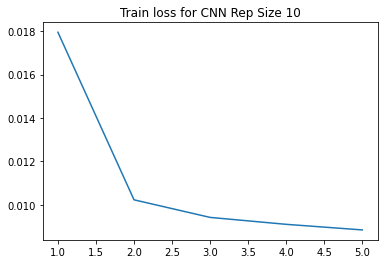

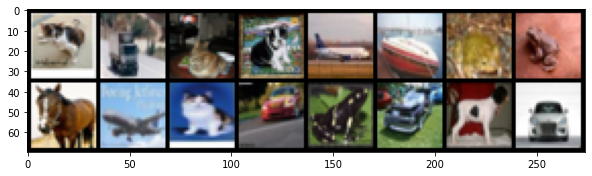

Reconstructed Images


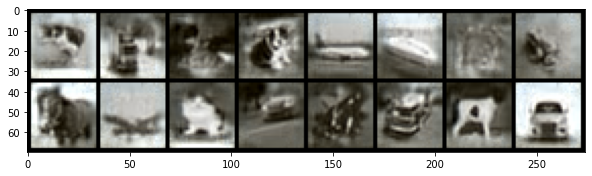


REPRESENTATION SIZE :  32
CNNAutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(3, 11, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(11, 22, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(22, 32, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 22, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(22, 11, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(11, 3, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU()
  )
)


100%|██████████| 3125/3125 [00:26<00:00, 117.77it/s]


EPOCH -  1  LOSS= 0.01002141756825149


100%|██████████| 3125/3125 [00:26<00:00, 117.22it/s]


EPOCH -  2  LOSS= 0.0037019096298515795


100%|██████████| 3125/3125 [00:26<00:00, 117.69it/s]


EPOCH -  3  LOSS= 0.003146235532462597


100%|██████████| 3125/3125 [00:26<00:00, 116.92it/s]


EPOCH -  4  LOSS= 0.0028297314598038793


100%|██████████| 3125/3125 [00:26<00:00, 117.30it/s]


EPOCH -  5  LOSS= 0.0026793386169523
Time Taken to train :  133.16538405418396

Original Images


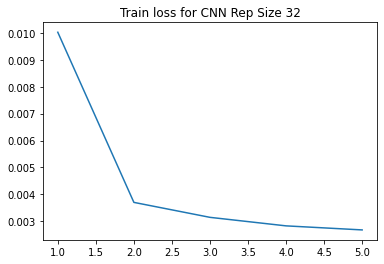

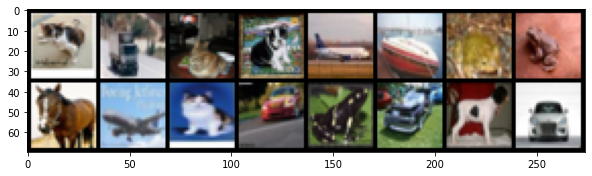

Reconstructed Images


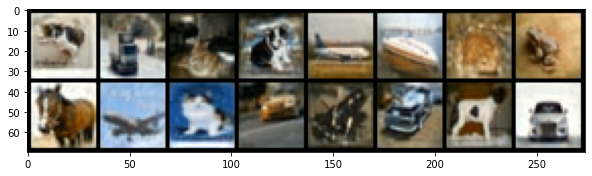


REPRESENTATION SIZE :  100
CNNAutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(3, 34, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(34, 67, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(67, 100, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(100, 67, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(67, 34, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(34, 3, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU()
  )
)


100%|██████████| 3125/3125 [00:29<00:00, 105.18it/s]


EPOCH -  1  LOSS= 0.00984155365690589


100%|██████████| 3125/3125 [00:29<00:00, 107.40it/s]


EPOCH -  2  LOSS= 0.003067233281955123


100%|██████████| 3125/3125 [00:29<00:00, 106.69it/s]


EPOCH -  3  LOSS= 0.00287096188981086


100%|██████████| 3125/3125 [00:30<00:00, 103.59it/s]


EPOCH -  4  LOSS= 0.0021152684280648826


100%|██████████| 3125/3125 [00:29<00:00, 105.39it/s]


EPOCH -  5  LOSS= 0.0020787722547724844
Time Taken to train :  147.9787266254425

Original Images


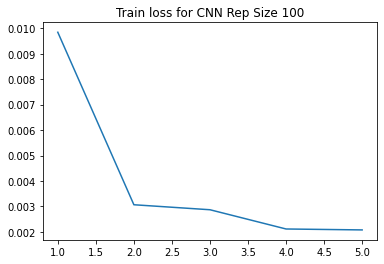

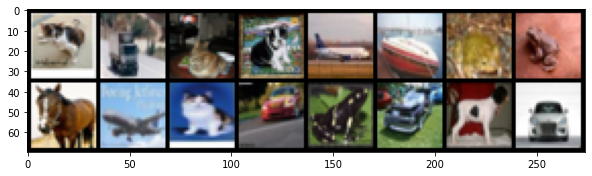

Reconstructed Images


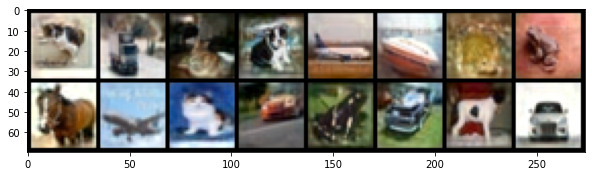


REPRESENTATION SIZE :  1000
CNNAutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(3, 334, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(334, 667, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(667, 1000, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(1000, 667, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(667, 334, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(334, 3, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU()
  )
)


 62%|██████▏   | 1933/3125 [14:07<08:42,  2.28it/s]


KeyboardInterrupt: ignored

In [ ]:
# # code and analysis here
# RepSizes = [10, 32, 100, 1000]

# criteria = nn.MSELoss()

# dataiter = iter(test_loader)
# images, labels = next(dataiter)
# images = images.to(device)

# for size in RepSizes:
#     print("REPRESENTATION SIZE : ", size)
#     modelCNN = CNNAutoEncoder(size).to(device)

#     optimizer = torch.optim.Adam(modelCNN.parameters(), lr=1e-3, weight_decay=1e-5)
#     print(modelCNN)
#     timeTakenCNN, lossListCNN = TrainModel(modelCNN, EPOCHS, train_loader, criteria, optimizer, p_reshape = False)

#     print("Time Taken to train : ", timeTakenCNN)
#     PlotLoss(EpochList, lossListCNN, "CNN Rep Size " + str(size))

#     print()
#     print("Original Images")
#     imshow(torchvision.utils.make_grid(images.cpu()))

#     print("Reconstructed Images")
#     decoded_images = modelCNN(images)[1]
#     imshow(torchvision.utils.make_grid(decoded_images.cpu()))

#     print()

### Step four: Varying the number of layers of Model
1. 1
2. 3
3. 5
4. 10

In [ ]:
# code and analysis here

In [ ]:
# ONE LAYER
class CNNAutoEncoder_ONE(nn.Module):
    # code
    def __init__(self):
        super(CNNAutoEncoder_ONE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=16, stride=16), # 8*2*2
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 3, kernel_size=16, stride=16),
            nn.ReLU(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return encoded, decoded

# FIVE LAYER
class CNNAutoEncoder_FIVE(nn.Module):
    # code
    def __init__(self):
        super(CNNAutoEncoder_FIVE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3,8,4,stride=2,padding=1),#N,8,16,16
            nn.ReLU(),
            nn.Conv2d(8,12,4,stride=2,padding=1),#N,12,8,8
            nn.ReLU(),
            nn.Conv2d(12,16,4,stride=2,padding=1), #N,16,4,4
            nn.ReLU(),
            nn.Conv2d(16,24,4,stride=2,padding=1),#24,2,2
            nn.ReLU(),
            nn.Conv2d(24,32,2),#32,1,1
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32,24,2),# 24,2,2
            nn.ReLU(),
            nn.ConvTranspose2d(24,16,4,stride=2,padding=1), #16,4,4
            nn.ReLU(),
            nn.ConvTranspose2d(16,12,4,stride=2,padding=1), # 12,8,8
            nn.ReLU(),
            nn.ConvTranspose2d(12,8,4,stride=2,padding=1), # 8,16,16
            nn.ReLU(),
            nn.ConvTranspose2d(8,3,4,stride=2,padding=1), # 3,32,32
            nn.ReLU()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return encoded, decoded


# TEN LAYER
class CNNAutoEncoder_TEN(nn.Module):
    # code
    def __init__(self):
        super(CNNAutoEncoder_TEN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3,4,3,stride=1),#N,4,30,30
            nn.ReLU(),
            nn.Conv2d(4,8,3,stride=1),#N,8,28,28
            nn.ReLU(),
            nn.Conv2d(8,12,3,stride=1), #N,12,26,26
            nn.ReLU(),
            nn.Conv2d(12,16,3,stride=1),#16,24,24
            nn.ReLU(),
            nn.Conv2d(16,18,4,stride=2,padding=1),#18,12,12
            nn.ReLU(),
            nn.Conv2d(18,20,3,stride=1),#N,20,10,10
            nn.ReLU(),
            nn.Conv2d(20,24,3,stride=1), #N,24,8,8
            nn.ReLU(),
            nn.Conv2d(24,28,4,stride=2,padding=1),#28,4,4
            nn.ReLU(),
            nn.Conv2d(28,30,4,stride=2,padding=1),#30,2,2
            nn.ReLU(),
            nn.Conv2d(30,32,2),#32,1,1
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32,30,2),# 24,2,2
            nn.ReLU(),
            nn.ConvTranspose2d(30,28,4,stride=2,padding=1), #16,4,4
            nn.ReLU(),
            nn.ConvTranspose2d(28,24,4,stride=2,padding=1), # 12,8,8
            nn.ReLU(),
            nn.ConvTranspose2d(24,20,3,stride=1), # 8,16,16
            nn.ReLU(),
            nn.ConvTranspose2d(20,18,3,stride=1), # 3,32,32
            nn.ReLU(),
            nn.ConvTranspose2d(18,16,4,stride=2,padding=1), #16,4,4
            nn.ReLU(),
            nn.ConvTranspose2d(16,12,3,stride=1), # 12,8,8
            nn.ReLU(),
            nn.ConvTranspose2d(12,8,3,stride=1), # 8,16,16
            nn.ReLU(),
            nn.ConvTranspose2d(8,4,3,stride=1), # 3,32,32
            nn.ReLU(),
            nn.ConvTranspose2d(4,3,3,stride=1),
            nn.ReLU()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return encoded, decoded

In [ ]:
criteria = nn.MSELoss()
dataiter = iter(test_loader)
images, labels = next(dataiter)
images = images.to(device)

Number of Layers = 1
CNNAutoEncoder_ONE(
  (encoder): Sequential(
    (0): Conv2d(3, 8, kernel_size=(16, 16), stride=(16, 16))
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(8, 3, kernel_size=(16, 16), stride=(16, 16))
    (1): ReLU()
  )
)


100%|██████████| 3125/3125 [00:18<00:00, 172.93it/s]


EPOCH -  1  LOSS= 0.01892007228642702


100%|██████████| 3125/3125 [00:22<00:00, 140.56it/s]


EPOCH -  2  LOSS= 0.0149277495059371


100%|██████████| 3125/3125 [00:26<00:00, 115.81it/s]


EPOCH -  3  LOSS= 0.014907122928500176


100%|██████████| 3125/3125 [00:17<00:00, 174.54it/s]


EPOCH -  4  LOSS= 0.014899528366029263


100%|██████████| 3125/3125 [00:17<00:00, 175.20it/s]


EPOCH -  5  LOSS= 0.014895100571811199
Time Taken to train for 1 Epoch:  20.614541435241698

Original Images


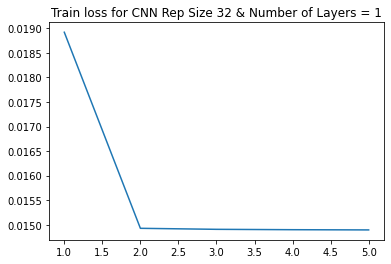

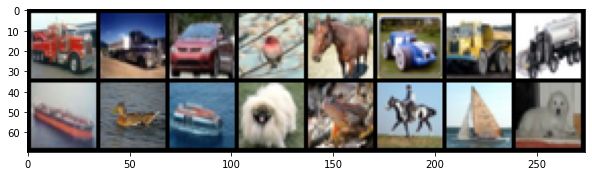

Reconstructed Images


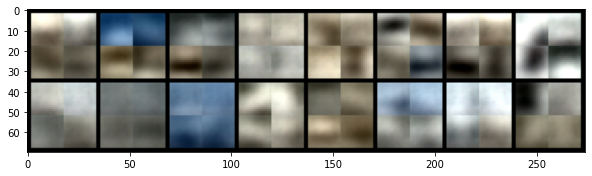

In [ ]:
# ONE Layer
print("Number of Layers = 1")
modelCNN = CNNAutoEncoder_ONE().to(device)

optimizer = torch.optim.Adam(modelCNN.parameters(), lr=1e-3, weight_decay=1e-5)
print(modelCNN)
timeTakenCNN, lossListCNN = TrainModel(modelCNN, EPOCHS, train_loader, criteria, optimizer, p_reshape = False)
print("Time Taken to train for 1 Epoch: ", timeTakenCNN/EPOCHS)
PlotLoss(EpochList, lossListCNN, "CNN Rep Size 32 & Number of Layers = 1")
print()
print("Original Images")
imshow(torchvision.utils.make_grid(images.cpu()))

print("Reconstructed Images")
decoded_images = modelCNN(images)[1]
imshow(torchvision.utils.make_grid(decoded_images.cpu()))
print()

Number of Layers = 3
CNNAutoEncoder_32(
  (encoder): Sequential(
    (0): Conv2d(3, 4, kernel_size=(4, 4), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(4, 6, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(6, 8, kernel_size=(4, 4), stride=(1, 1))
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(8, 6, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(6, 4, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): ConvTranspose2d(4, 3, kernel_size=(4, 4), stride=(2, 2))
    (5): ReLU()
  )
)


100%|██████████| 3125/3125 [00:24<00:00, 126.96it/s]


EPOCH -  1  LOSS= 0.023506319563388823


100%|██████████| 3125/3125 [00:25<00:00, 121.64it/s]


EPOCH -  2  LOSS= 0.015461342639327049


100%|██████████| 3125/3125 [00:24<00:00, 127.17it/s]


EPOCH -  3  LOSS= 0.014620313893556594


100%|██████████| 3125/3125 [00:23<00:00, 130.44it/s]


EPOCH -  4  LOSS= 0.012894386942088604


100%|██████████| 3125/3125 [00:24<00:00, 129.68it/s]


EPOCH -  5  LOSS= 0.011350713399648667
Time Taken to train for 1 Epoch:  24.59569902420044

Original Images


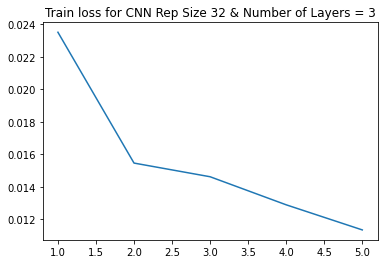

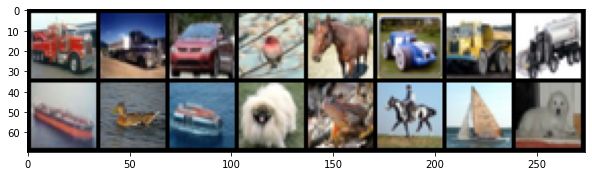

Reconstructed Images


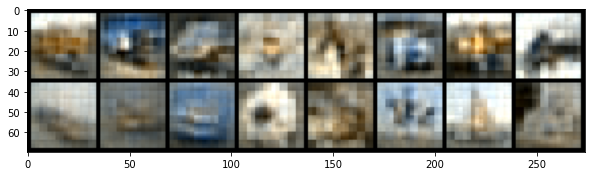

In [ ]:
# 3 Layers
print("Number of Layers = 3")
modelCNN = CNNAutoEncoder_32().to(device)

optimizer = torch.optim.Adam(modelCNN.parameters(), lr=1e-3, weight_decay=1e-5)
print(modelCNN)
timeTakenCNN, lossListCNN = TrainModel(modelCNN, EPOCHS, train_loader, criteria, optimizer, p_reshape = False)

print("Time Taken to train for 1 Epoch: ", timeTakenCNN/EPOCHS)
PlotLoss(EpochList, lossListCNN, "CNN Rep Size 32 & Number of Layers = 3")

print()
print("Original Images")
imshow(torchvision.utils.make_grid(images.cpu()))

print("Reconstructed Images")
decoded_images = modelCNN(images)[1]
imshow(torchvision.utils.make_grid(decoded_images.cpu()))

print()

Number of Layers = 5
CNNAutoEncoder_FIVE(
  (encoder): Sequential(
    (0): Conv2d(3, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(12, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(16, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(24, 32, kernel_size=(2, 2), stride=(1, 1))
    (9): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 24, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(24, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(16, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(12, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): ConvTranspose2d(8, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
   

100%|██████████| 3125/3125 [00:31<00:00, 99.66it/s]


EPOCH -  1  LOSS= 0.030199821163415907


100%|██████████| 3125/3125 [00:31<00:00, 98.82it/s] 


EPOCH -  2  LOSS= 0.021075231515467165


100%|██████████| 3125/3125 [00:32<00:00, 96.39it/s] 


EPOCH -  3  LOSS= 0.01905332023650408


100%|██████████| 3125/3125 [00:31<00:00, 100.72it/s]


EPOCH -  4  LOSS= 0.017604688412845133


100%|██████████| 3125/3125 [00:31<00:00, 98.16it/s] 


EPOCH -  5  LOSS= 0.016538100624382497
Time Taken to train for 1 Epoch:  31.663121128082274

Original Images


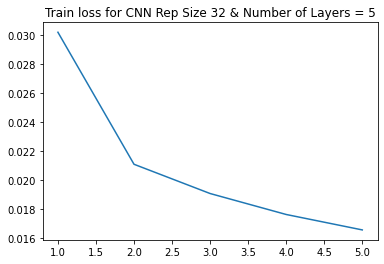

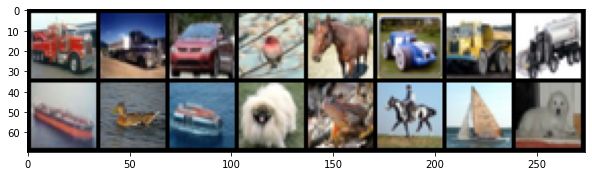

Reconstructed Images


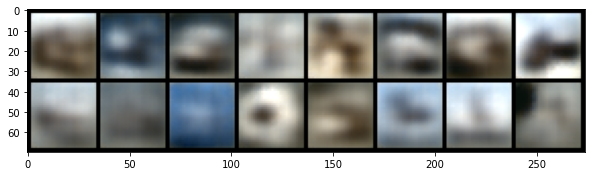

In [ ]:
# FIVE Layer
print("Number of Layers = 5")
modelCNN = CNNAutoEncoder_FIVE().to(device)

optimizer = torch.optim.Adam(modelCNN.parameters(), lr=1e-3, weight_decay=1e-5)
print(modelCNN)
timeTakenCNN, lossListCNN = TrainModel(modelCNN, EPOCHS, train_loader, criteria, optimizer, p_reshape = False)
print("Time Taken to train for 1 Epoch: ", timeTakenCNN/EPOCHS)
PlotLoss(EpochList, lossListCNN, "CNN Rep Size 32 & Number of Layers = 5")
print()
print("Original Images")
imshow(torchvision.utils.make_grid(images.cpu()))

print("Reconstructed Images")
decoded_images = modelCNN(images)[1]
imshow(torchvision.utils.make_grid(decoded_images.cpu()))
print()

Number of Layers = 10
CNNAutoEncoder_TEN(
  (encoder): Sequential(
    (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(8, 12, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Conv2d(12, 16, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): Conv2d(16, 18, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(18, 20, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU()
    (12): Conv2d(20, 24, kernel_size=(3, 3), stride=(1, 1))
    (13): ReLU()
    (14): Conv2d(24, 28, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (15): ReLU()
    (16): Conv2d(28, 30, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (17): ReLU()
    (18): Conv2d(30, 32, kernel_size=(2, 2), stride=(1, 1))
    (19): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 30, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): ConvTran

100%|██████████| 3125/3125 [00:48<00:00, 64.52it/s]


EPOCH -  1  LOSS= 0.07083910168766976


100%|██████████| 3125/3125 [00:48<00:00, 64.28it/s]


EPOCH -  2  LOSS= 0.06231853825569153


100%|██████████| 3125/3125 [00:48<00:00, 64.46it/s]


EPOCH -  3  LOSS= 0.06220353841304779


100%|██████████| 3125/3125 [00:49<00:00, 62.57it/s]


EPOCH -  4  LOSS= 0.06215166108489036


100%|██████████| 3125/3125 [00:48<00:00, 64.66it/s]


EPOCH -  5  LOSS= 0.0621241906619072
Time Taken to train for 1 Epoch:  48.77197194099426

Original Images


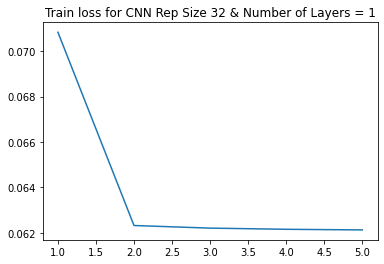

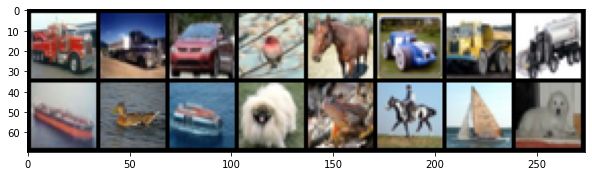

Reconstructed Images


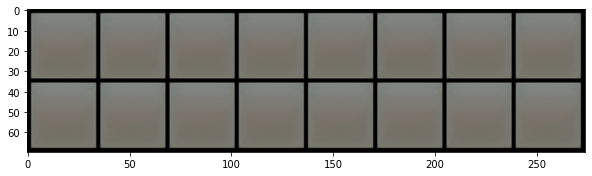

In [ ]:
# TEN Layer
print("Number of Layers = 10")
modelCNN = CNNAutoEncoder_TEN().to(device)

optimizer = torch.optim.Adam(modelCNN.parameters(), lr=1e-3, weight_decay=1e-5)
print(modelCNN)
timeTakenCNN, lossListCNN = TrainModel(modelCNN, EPOCHS, train_loader, criteria, optimizer, p_reshape = False)
print("Time Taken to train for 1 Epoch: ", timeTakenCNN/EPOCHS)
PlotLoss(EpochList, lossListCNN, "CNN Rep Size 32 & Number of Layers = 1")
print()
print("Original Images")
imshow(torchvision.utils.make_grid(images.cpu()))

print("Reconstructed Images")
decoded_images = modelCNN(images)[1]
imshow(torchvision.utils.make_grid(decoded_images.cpu()))
print()

Increasing number of layers of the network (Deeper network) will cause model to train better and hence will produce good image construction results. However, we can observe that more deeper network is causing Model to overfit and bad reconstructed images.
I could observe that number of Layers>4 is causing model to overfi, thereby reducing the image reconstructed quality.

In [ ]:
# explainations here
Autoencoder is an unsupervised neural network architecture that can learn a compressed representation of the input data by encoding it into a lower-dimensional space and then decoding it back to the original input.
Autoencoder consists of an encoder that compresses the data into a lower-dimensional space and a decoder that reconstructs the data from the compressed representation.
Autoencoder differs from other data representation methods like PCA and t-SNE in that it can learn non-linear representations of the input data, whereas PCA and t-SNE can only learn linear and non-linear representations respectively.

Analysis -
Increasing the representation size and having a deeper network will help in better learning of the model and hence better image reconstruction quality. However, large increase of them will also lead to overfitting of model which is not desired.
We have to choose an optimum value for representation size and number of layers which can give decent output.


## Part 2: Image Classifier
Autoencoder representations can be useful for a wide range of machine learning tasks beyond just reconstructing input data. For example, the output of an encoder can be used as a feature representation for classification using k-Nearest Neighbors (kNN) or other classifiers. Similarly, the encoded representations can be used for unsupervised tasks like clustering, where the model groups similar images together based on their feature representation. This makes autoencoders a versatile tool for feature learning, with the potential to enhance the performance of a wide range of machine learning algorithms.

In [ ]:
# code and analysis here. Remember to keep your analysis of high quality at all times.
train_loader_2 = torch.utils.data.DataLoader(train_dataset, batch_size = 1, shuffle = True, num_workers = 2)
test_loader_2 = torch.utils.data.DataLoader(test_dataset, batch_size = 1, shuffle = True, num_workers = 2)

In [ ]:
X_Train = []
Y_Train = []
for x, y in tqdm(train_loader_2):
    # X_Train.append(np.array(x.reshape(1, 3072)).flatten())
    x = x.to(device)
    X_Train.append(modelCNN_10(x)[0].reshape(-1).cpu().detach().numpy())
    Y_Train.append(y.item())

100%|██████████| 50000/50000 [02:39<00:00, 314.22it/s]


In [ ]:
X_Test = []
Y_Test = []
for x, y in tqdm(test_loader_2):
    # X_Test.append(np.array(x.reshape(1, 3072)).flatten())
    x = x.to(device)
    X_Test.append(modelCNN_10(x)[0].reshape(-1).cpu().detach().numpy())
    Y_Test.append(y.item())

In [ ]:
X_extra,X_Train,y_extra,Y_Train = train_test_split(X_Train, Y_Train, test_size = 0.2)
X_extra,X_Test,y_extra,Y_Test = train_test_split(X_Test, Y_Test, test_size = 0.1)

print(len(X_Train))
print(len(X_Test))

10000
1000


In [ ]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_Train, Y_Train)

pred = knn.predict(X_Test)
print(classification_report(Y_Test, pred))

              precision    recall  f1-score   support

           0       0.34      0.58      0.43        90
           1       0.35      0.33      0.34        94
           2       0.23      0.35      0.28        96
           3       0.23      0.16      0.19        99
           4       0.25      0.28      0.27       115
           5       0.37      0.22      0.27       115
           6       0.24      0.25      0.24       104
           7       0.29      0.25      0.27        89
           8       0.39      0.40      0.39        96
           9       0.49      0.30      0.38       102

    accuracy                           0.31      1000
   macro avg       0.32      0.31      0.31      1000
weighted avg       0.32      0.31      0.30      1000



Analysis -
Though KNN is able to classify the data from the encoded output of Auto-Encoder, it is not considered to be an efficient method as we can notice that accuracy is not upto acceptable values. This can also happend as we have choosen model with Representation size=10 which was also not giving good results.